# 识别手写数字

### Necessary Imports

In [1]:
#Scientific computing 
import numpy as np

#Pytorch packages   
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

#Visulization
import matplotlib.pyplot as plt

#Others
import time
import copy

### Download The Dataset & Define The Transforms

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([
                              transforms.RandomRotation(degrees=12),  
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('data/', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

class_names = trainset.classes
dataset_sizes = {'train':len(trainset), 'val':len(valset)}
dataloaders  = {'train':trainloader, 'val':valloader}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Exploring The Data

In [3]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


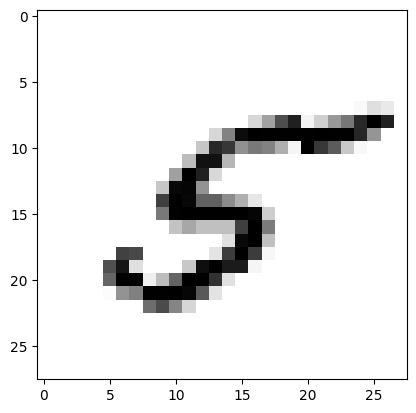

In [4]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

### Defining LeNet-5

In [5]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 16*4*4)
        x = self.classifier(x)
        return x

In [6]:
model = LeNet5()
model

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [7]:
optimizer = optim.Adam(params=model.parameters(), lr=0.0004)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.4)

if torch.cuda.is_available():
    model = model.to(device)
    criterion = criterion.to(device)

### Train and evaluate

In [8]:
def train_model(model, criterion, optimizer, scheduler, dataset_sizes, dataloaders, num_epochs=25 ):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # 记录训练过程数据
    train_loss_history = []
    val_loss_history = []  
    val_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]


            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss) 
                val_acc_history.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    train_loss_history = [float(loss) for loss in train_loss_history]
    val_loss_history = [float(loss) for loss in val_loss_history]
    val_acc_history = [float(acc) for acc in val_acc_history]

    plt.figure(figsize=(8, 6)) 
    plt.plot(train_loss_history, 'b-', label='train_loss')
    plt.plot(val_loss_history, 'orange', label='test_loss') 
    plt.plot(val_acc_history, 'g-', label='accuracy_on_testset')
    plt.xlabel('epoch')
    plt.ylabel('loss/accuracy') 
    plt.title('CIFAR-10')
    plt.legend()
    plt.grid(True)
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/24
----------
train Loss: 0.4127 Acc: 0.8751
val Loss: 0.1324 Acc: 0.9591

Epoch 1/24
----------
train Loss: 0.1255 Acc: 0.9611
val Loss: 0.0859 Acc: 0.9741

Epoch 2/24
----------
train Loss: 0.0917 Acc: 0.9718
val Loss: 0.0687 Acc: 0.9784

Epoch 3/24
----------
train Loss: 0.0746 Acc: 0.9768
val Loss: 0.0621 Acc: 0.9796

Epoch 4/24
----------
train Loss: 0.0638 Acc: 0.9804
val Loss: 0.0487 Acc: 0.9834

Epoch 5/24
----------
train Loss: 0.0578 Acc: 0.9815
val Loss: 0.0517 Acc: 0.9835

Epoch 6/24
----------
train Loss: 0.0446 Acc: 0.9860
val Loss: 0.0418 Acc: 0.9873

Epoch 7/24
----------
train Loss: 0.0435 Acc: 0.9867
val Loss: 0.0411 Acc: 0.9864

Epoch 8/24
----------
train Loss: 0.0411 Acc: 0.9872
val Loss: 0.0401 Acc: 0.9867

Epoch 9/24
----------
train Loss: 0.0390 Acc: 0.9878
val Loss: 0.0366 Acc: 0.9885

Epoch 10/24
----------
train Loss: 0.0360 Acc: 0.9887
val Loss: 0.0399 Acc: 0.9876

Epoch 11/24
----------
train Loss: 0.0348 Acc: 0.9889
val Loss: 0.0366 Acc: 0.9880

Ep

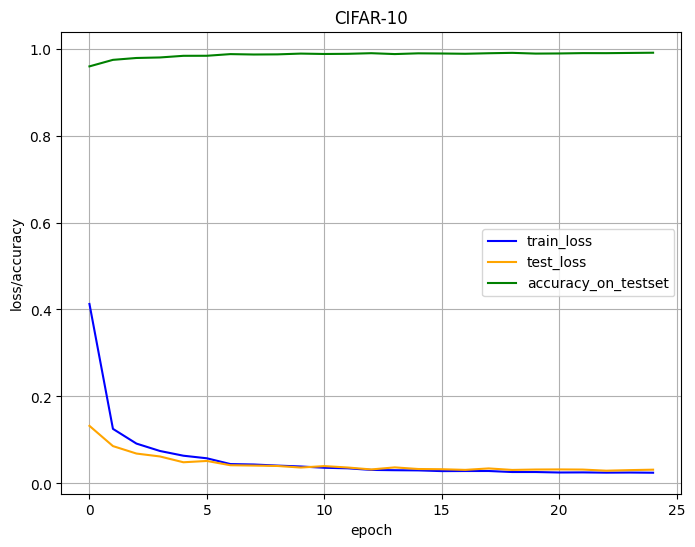

In [9]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,dataset_sizes,dataloaders,num_epochs=25)

## Visualizing the model predictions

In [10]:
def imshow(inp, title=None):
    inp = inp.numpy().squeeze()
    plt.imshow(inp, cmap='gray_r')
    if title is not None:
        plt.title(title)

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))

                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.show()
                    return
        model.train(mode=was_training)


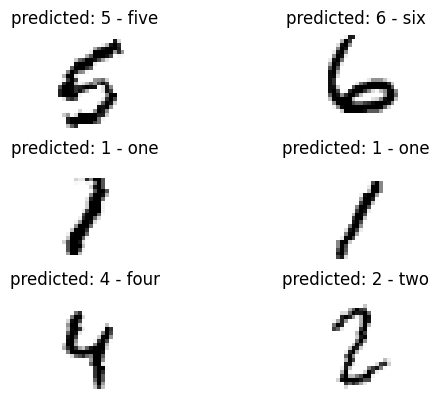

In [12]:
visualize_model(model)

In [13]:
torch.save(model, './my_mnist_model.pt') 

In [14]:
def report_misclassifications(model, dataloader, device, num_images=10):
    model.eval()
    misclassified = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # 找出预测错误的图像
            mask = preds != labels
            if mask.any():
                wrong_images = images[mask]
                wrong_labels = labels[mask]
                wrong_preds = preds[mask]
                
                for img, true_label, pred_label in zip(wrong_images, wrong_labels, wrong_preds):
                    misclassified.append((img, true_label, pred_label))
                    if len(misclassified) >= num_images:
                        break
            if len(misclassified) >= num_images:
                break
    
    # 可视化错误分类
    fig = plt.figure(figsize=(12, 5))
    for idx, (img, true_label, pred_label) in enumerate(misclassified[:num_images]):
        ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
        img = img.cpu().numpy().squeeze()
        plt.imshow(img, cmap='gray')
        ax.set_title(f'True: {true_label.item()}\nPred: {pred_label.item()}',
                    color=("green" if true_label == pred_label else "red"))
    plt.tight_layout()
    plt.show()
    
    return misclassified

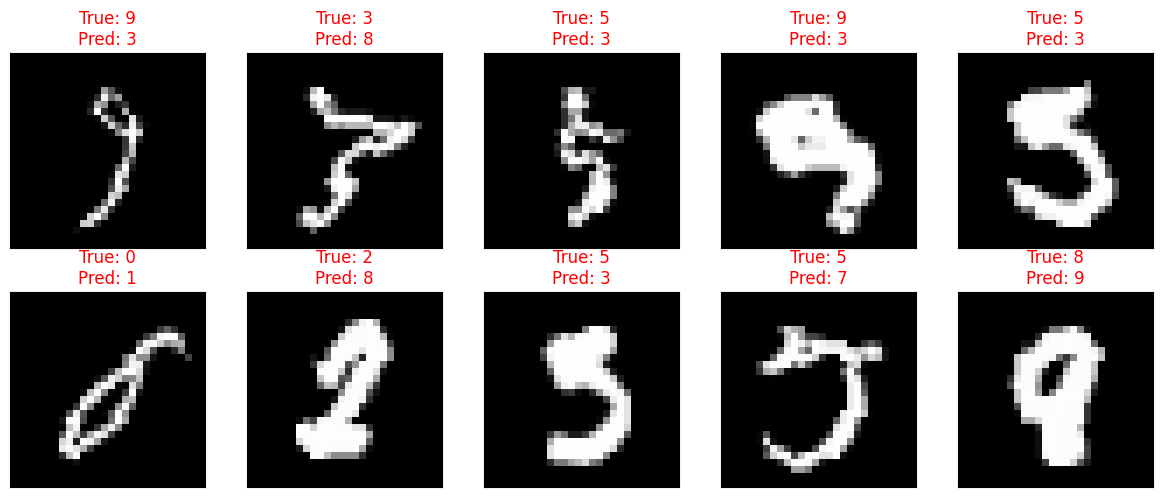

In [15]:
misclassified = report_misclassifications(model, valloader, device)

In [17]:
# 计算整个验证集的F1分数
true_labels_all = []
predicted_labels_all = []

# 检查是否有可用的GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 将模型移到指定设备
model.to(device)
model.eval()

with torch.no_grad():
    for images, labels in dataloaders['val']:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        
        true_labels_all.extend(labels.cpu().numpy())
        predicted_labels_all.extend(predicted.cpu().numpy())

# 计算F1分数
f1 = f1_score(true_labels_all, predicted_labels_all, average='macro')
print(f'F1 Score: {f1:.4f}')

Using device: cpu
F1 Score: 0.9892


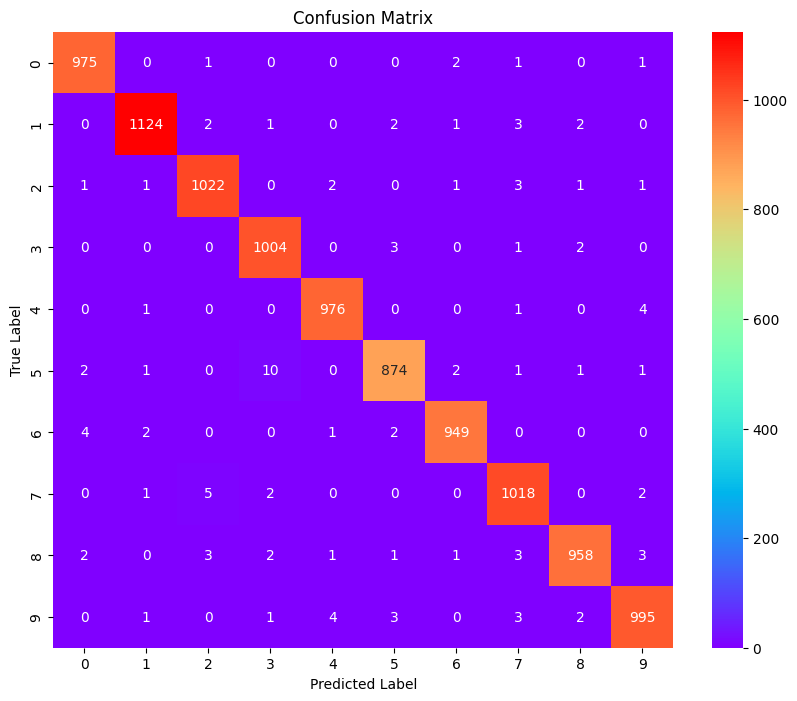

In [29]:
# 收集真实标签和预测标签
true_labels_all = []
predicted_labels_all = []

model.eval()  # 将模型设置为评估模式
with torch.no_grad():  # 不计算梯度，节省内存
    for images, labels in dataloaders['val']:
        outputs = model(images)  # 模型预测
        _, predicted = torch.max(outputs, 1)  # 获取预测结果
        
        true_labels_all.extend(labels.numpy())
        predicted_labels_all.extend(predicted.numpy())

# 创建混淆矩阵
cm = confusion_matrix(true_labels_all, predicted_labels_all)
plt.figure(figsize=(10,8))
# 这里可以选择不同的颜色方案
sns.heatmap(cm, annot=True, fmt='d', cmap='rainbow')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [26]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in dataloaders['val']:
        # 不需要移到GPU
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # 直接转换为numpy数组，不需要cpu()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# 打印分类报告
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



# 比较三个模型

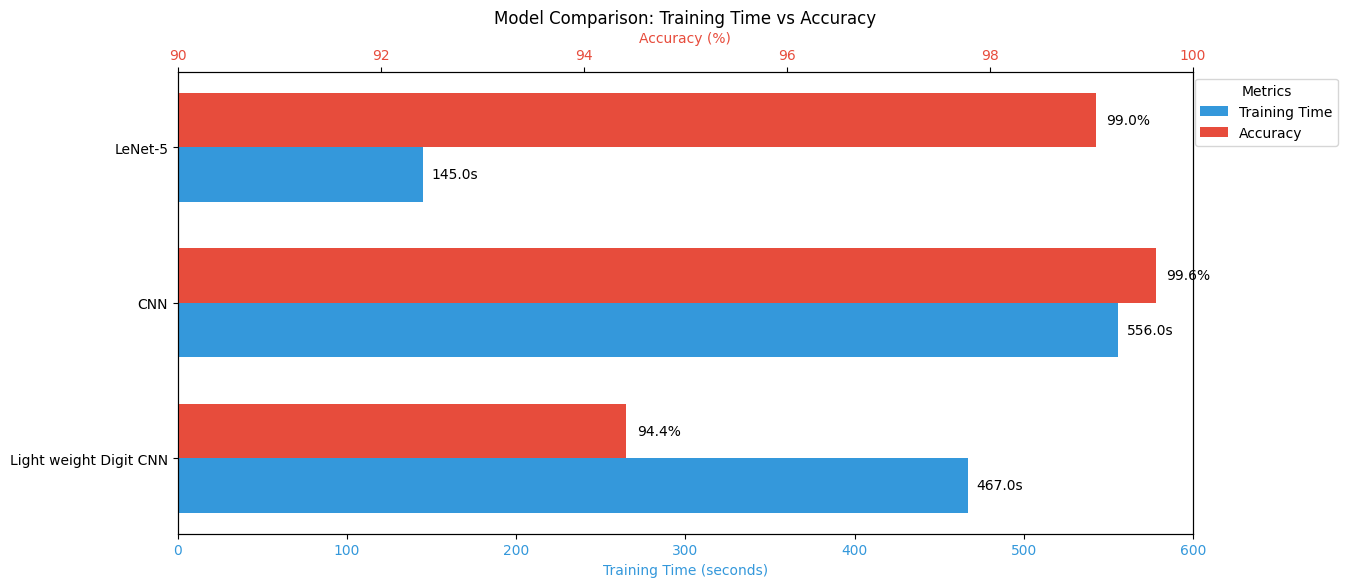

In [7]:

models = ['Light weight Digit CNN', 'CNN', 'LeNet-5']
training_time = np.array([467, 556, 145])  # 交换了前两个值
accuracy = np.array([94.42, 99.64, 99.05])  # 交换了前两个值

# 创建单个图形，并设置更大的右边距来容纳图例
plt.figure(figsize=(14, 6))

# 设置条形的位置
y = np.arange(len(models))
height = 0.35  # 条形的高度

# 创建双轴
ax1 = plt.gca()
ax2 = ax1.twiny()

# 训练时间条形图（使用下轴）
bars1 = ax1.barh(y - height/2, training_time, height, color='#3498db', label='Training Time')
ax1.set_xlabel('Training Time (seconds)', color='#3498db')
ax1.tick_params(axis='x', labelcolor='#3498db')

# 准确率条形图（使用上轴）
bars2 = ax2.barh(y + height/2, accuracy, height, color='#e74c3c', label='Accuracy')
ax2.set_xlabel('Accuracy (%)', color='#e74c3c')
ax2.tick_params(axis='x', labelcolor='#e74c3c')

# 设置y轴标签
plt.yticks(y, models)

# 在条形上添加数值标签
def autolabel(bars, ax, offset=5):
    for bar in bars:
        width = bar.get_width()
        ax.text(width + offset, bar.get_y() + bar.get_height()/2,
                f'{width:.1f}{"s" if width > 100 else "%"}',
                ha='left', va='center')

# 为训练时间和准确率设置不同的偏移量
autolabel(bars1, ax1, offset=5)  # 训练时间保持原来的偏移量
autolabel(bars2, ax2, offset=0.1)  # 准确率使用更小的偏移量

# 设置x轴范围
ax1.set_xlim(0, 600)  # 训练时间范围
ax2.set_xlim(90, 100)  # 准确率范围

# 添加标题
plt.title('Model Comparison: Training Time vs Accuracy')

# 将图例放到图片外面
plt.legend(handles=[bars1, bars2], 
          bbox_to_anchor=(1.15, 1), 
          loc='upper right',
          title='Metrics')

# 调整布局以确保图例不被截断
plt.subplots_adjust(right=0.85)

# 显示图形
plt.show()